## Severe Weather Forecasting with Python and Data Science Tools: Interactive Demo
David John Gagne, University of Oklahoma and NCAR


## Introduction
Severe weather forecasting has entered an age of unprecedented access to large model and observational datasets with even greater hordes of data in the pipeline. With multiple ensembles of convection-allowing models available and an increasing variety of observations derived from radar, satellite, surface, upper air, and crowd-sourcing, forecasters can easily be overwhelmed with guidance. Without ways to organize, synthesize, and visualize the data in a useful manner for forecasters, the pile of new models and observations will languish unused and will not fulfill their full potential. An even worse outcome would be to take the human forecasters completely out of the loop and trust the models, which is a way fraught with peril. Data science tools offer ways to synthesize essential information from many disparate data sources while also quantifying uncertainty. When forecasters use the tools properly, they can identify potential hazards and the associated spatial and time uncertainties more quickly by using the output of the tools to help target their domain knowledge. 

This module demonstrates how data science tools from the image processing and machine learning families can be used to create a forecast of severe hail. It aims to teach the advantages, challenges, and limitations of these tools through hands-on interaction. 

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from mpl_toolkits.basemap import Basemap
from IPython.display import display, Image
from ipywidgets import widgets, interact
from scipy.ndimage import gaussian_filter, find_objects
from copy import deepcopy
from glob import glob

## Part 1: Storm Track Identification
We will be using the hagelslag library to perform object-based data processing of convection-allowing model output. 

In [2]:
from hagelslag.processing import EnhancedWatershed
from hagelslag.data import ModelOutput
from hagelslag.processing import ObjectMatcher, shifted_centroid_distance, centroid_distance
from hagelslag.processing import STObject

We will be using model output from the control run of the Center for Analysis and Prediction of Storms 2015 Storm-Scale Ensemble Forecast system. The model output for this exercise is included with the hagelslag package, but additional variables can be downloaded from the Unidata RAMADDA server or from [my personal page](http://www.caps.ou.edu/~djgagne/spring2015_unidata.tar.gz). Please untar the data in a local directory and modify the `model_path` variable below to point to the spring2015_unidata directory.

In [3]:
model_path = "../testdata/spring2015_unidata/"
ensemble_name = "SSEF"
member ="wrf-s3cn_arw"
run_date = datetime(2015, 6, 4)
# We will be using the uh_max (hourly max 2-5 km Updraft Helicity) variable for this exercise
# cmpref (simulated composite radar reflectivity) is also available.
variable = "uh_max"
start_date = run_date + timedelta(hours=12)
end_date = run_date + timedelta(hours=29)
model_grid = ModelOutput(ensemble_name, 
                         member, 
                         run_date, 
                         variable, 
                         start_date, 
                         end_date,
                         model_path,
                         single_step=False)
model_grid.load_data()
model_grid.load_map_info("../mapfiles/ssef2015.map")

The max updraft helicity map over the full period shows mutiple long and intense tracks in the central Plains. 

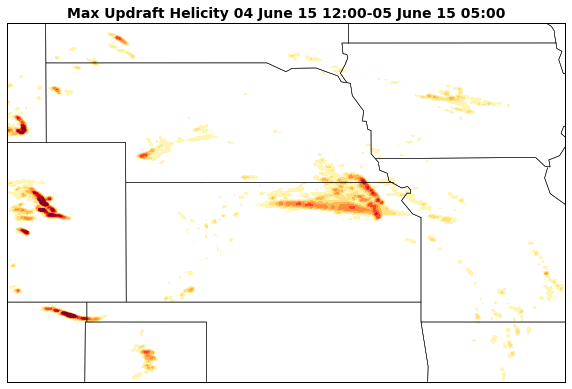

In [18]:
lon_range = (-105, -91)
lat_range = (35, 44)
basemap = Basemap(projection="cyl", 
                  resolution="l",
                  llcrnrlon=lon_range[0], 
                  urcrnrlon=lon_range[1],
                  llcrnrlat=lat_range[0],
                  urcrnrlat=lat_range[1])
plt.figure(figsize=(10,8))
basemap.drawstates()
plt.contourf(model_grid.lon, 
             model_grid.lat, 
             model_grid.data.max(axis=0), 
             np.arange(25,225,25), 
             extend="max",
             cmap="YlOrRd")
#plt.colorbar(shrink=0.6, fraction=0.05, pad=0.02 )
title_info = plt.title("Max Updraft Helicity {0}-{1}".format(start_date.strftime("%d %B %y %H:%M"), 
                                                             end_date.strftime("%d %B %y %H:%M")),
                      fontweight="bold", fontsize=14)
plt.savefig("uh_swaths.png", dpi=200, bbox_inches="tight")

To investigate the timing of the tracks, we can use this interactive widget to explore the tracks through time and to zoom in on areas of interest.

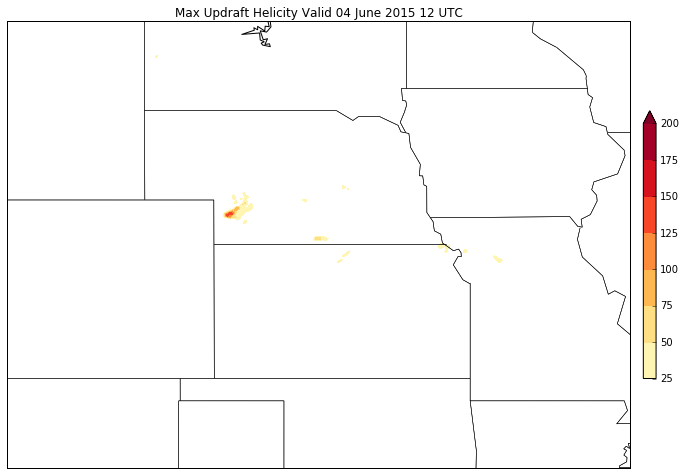

In [5]:
zoomable_bmap = Basemap(projection="cyl", 
                        resolution="l", 
                        llcrnrlon=model_grid.lon.min(),
                        llcrnrlat=model_grid.lat.min(),
                        urcrnrlon=model_grid.lon.max(),
                        urcrnrlat=model_grid.lat.max(),
                        fix_aspect=False)
def model_time_viewer(lon_range, lat_range, hour):
    #lon_range = (-108, -90)
    #lat_range = (35, 45)
    #basemap = Basemap(projection="cyl", 
    #                  resolution="l",
    #                  llcrnrlon=lon_range[0], 
    #                  urcrnrlon=lon_range[1],
    #                  llcrnrlat=lat_range[0],
    #                  urcrnrlat=lat_range[1])
    plt.figure(figsize=(12,8))
    zoomable_bmap.drawstates()
    zoomable_bmap.drawcoastlines()
    zoomable_bmap.drawcountries()
    plt.contourf(model_grid.lon, 
                 model_grid.lat, 
                 model_grid.data[hour - model_grid.start_hour], 
                 np.arange(25,225,25), 
                 extend="max",
                 cmap="YlOrRd")
    plt.colorbar(shrink=0.6, fraction=0.05, pad=0.02)
    title_info = plt.title("Max Updraft Helicity Valid {0}".format((run_date + timedelta(hours=hour)).strftime(
                "%d %B %Y %H UTC")))
    plt.xlim(*lon_range)
    plt.ylim(*lat_range)
lon_slider = widgets.IntRangeSlider(min=int(model_grid.lon.min()), 
                                    max=int(model_grid.lon.max()), 
                                    step=1, value=(-108, -90))
lat_slider = widgets.IntRangeSlider(min=int(model_grid.lat.min()), 
                                    max=int(model_grid.lat.max()), 
                                    value=(35,45),
                                    step=1)
hour_slider = widgets.IntSlider(min=model_grid.start_hour, max=model_grid.end_hour, step=1, value=0)
w = widgets.interactive(model_time_viewer, lon_range=lon_slider, lat_range=lat_slider, hour=hour_slider)
display(w)

### Storm Track Identification with the Enhanced Watershed
Our first data science tool is the enhanced watershed (Lakshmanan 2009), which is used for identifying features in gridded data. The original watershed transform identifies regions from an image or grid by finding local maxima and then growing objects from those maxima in discrete steps by looking for adjacent pixels with at least a certain intensity in an iterative fashion. The traditional watershed uses an intensity threshold as the stopping criterion for growth, which can produce unrealistic looking objects. The enhanced watershed first discretizes the data and then uses size and relative intensity thresholds to identify discrete objects. Buffer regions are also created around each object.

The enhanced watershed has the following tunable parameters:
* min, step, max: parameters to quantize the grid into a discrete number of levels
* size: growth of an object is stopped after it reaches the specified number of grid points in area
* delta: the maximum range of values contained within an object

##### Exercise: Manual Tuning
Pick a model time step and tune the enhanced watershed parameters until the objects look reasonable. Note how changing parameter values affects the shape of the objects. See how your chosen set of parameters handles other time steps. Finally, see what parameter settings produce particularly poor objects. If you find either a particularly good representation or a hilariously bad one, right-click the image, save it, and email the image to me at djgagne@ou.edu.

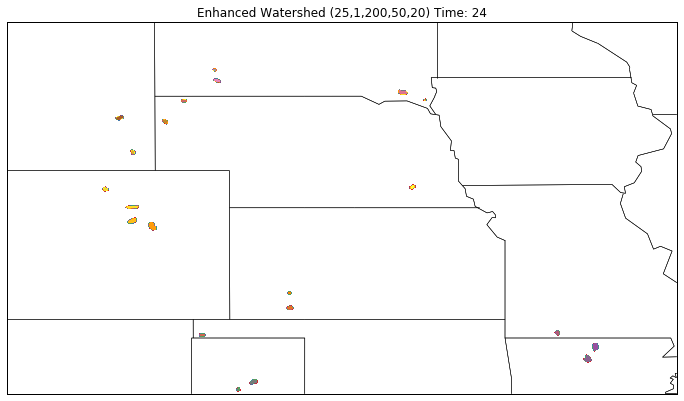

In [6]:
def ew_demo(min_max, step_val, size_val=50, delta_val=5, time=12):
    ew = EnhancedWatershed(min_max[0],step_val,min_max[1],size_val,delta_val)
    plt.figure(figsize=(12,8))
    basemap.drawstates()
    labels = ew.label(gaussian_filter(model_grid.data[time - model_grid.start_hour], 1))
    plt.contourf(model_grid.lon, 
                 model_grid.lat, 
                 labels, 
                 np.arange(1,labels.max()), 
                 extend="max",
                 cmap="Set1")
    plt.xlim(*lon_range)
    plt.ylim(*lat_range)
    plt.grid()
    plt.title("Enhanced Watershed ({0:d},{1:d},{2:d},{3:d},{4:d}) Time: {5:d}".format(min_max[0], 
                                                                                      step_val, 
                                                                                      min_max[1], 
                                                                                      size_val, 
                                                                                      delta_val, 
                                                                                      time))
minmax_slider = widgets.IntRangeSlider(min=10, max=300, step=10, value=(25,200))
step_slider = widgets.IntSlider(min=1, max=10, step=1, value=1)
size_slider = widgets.IntSlider(min=5, max=200, step=5, value=50)
delta_slider = widgets.IntSlider(min=10, max=200, step=10, value=20)
time_slider = widgets.IntSlider(min=model_grid.start_hour, max=model_grid.end_hour, step=1, value=24)
w = widgets.interactive(ew_demo, 
                        min_max=minmax_slider,          
                        step_val=step_slider, 
                        size_val=size_slider, 
                        delta_val=delta_slider,
                        time=time_slider)
display(w)

Once you find a desirable set of enhanced watershed parameters, input them below and generate storm objects for all time steps.

In [7]:
def get_forecast_objects(model_grid, ew_params, min_size, gaussian_window):
    ew = EnhancedWatershed(*ew_params)
    model_objects = []
    print "Find model objects Hour:",
    for h, hour in enumerate(np.arange(model_grid.start_hour, model_grid.end_hour + 1)):
        print "{0:02d}".format(hour),
        hour_labels = ew.size_filter(ew.label(gaussian_filter(model_grid.data[h], gaussian_window)), min_size)
        obj_slices = find_objects(hour_labels)
        num_slices = len(obj_slices)
        model_objects.append([])
        if num_slices > 0:
            for sl in obj_slices:   
                model_objects[-1].append(STObject(model_grid.data[h][sl],
                                                  np.where(hour_labels[sl] > 0, 1, 0),
                                                  model_grid.x[sl], 
                                                  model_grid.y[sl], 
                                                  model_grid.i[sl], 
                                                  model_grid.j[sl],
                                                  hour,
                                                  hour,
                                                  dx=3000))
                if h > 0:
                    dims = model_objects[-1][-1].timesteps[0].shape
                    model_objects[-1][-1].estimate_motion(hour, model_grid.data[h-1], dims[1], dims[0])
    return model_objects

min_thresh = 20
max_thresh = 200
step = 1
max_size = 90
min_size = 20
delta = 100
gaussian_filter_size = 2

model_objects = get_forecast_objects(model_grid, (min_thresh, step, max_thresh, max_size, delta), 
                                     min_size, gaussian_filter_size)

Find model objects Hour: 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29


###Object Tracking
Tracking storms over time provides useful information about their evolution and threat potential. However, storm tracking is a challenging problem due to storms forming, splitting, merging, and dying. Basic object-based storm tracking methods compare the locations of storms at one time step with the locations at the previous time steps and then find an optimal way to match storms from the two sets appropriately. 

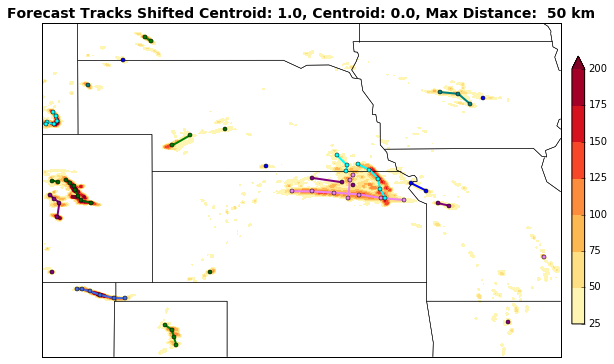

In [24]:
def track_forecast_objects(input_model_objects, model_grid, object_matcher):
    model_objects = deepcopy(input_model_objects)
    hours = np.arange(int(model_grid.start_hour), int(model_grid.end_hour) + 1)
    tracked_model_objects = []
    for h, hour in enumerate(hours):
        past_time_objs = []
        for obj in tracked_model_objects:
            # Potential trackable objects are identified
            if obj.end_time == hour - 1:
                past_time_objs.append(obj)
        # If no objects existed in the last time step, then consider objects in current time step all new
        if len(past_time_objs) == 0:
            tracked_model_objects.extend(deepcopy(model_objects[h]))
        # Match from previous time step with current time step
        elif len(past_time_objs) > 0 and len(model_objects[h]) > 0:
            assignments = object_matcher.match_objects(past_time_objs, model_objects[h], hour - 1, hour)
            unpaired = range(len(model_objects[h]))
            for pair in assignments:
                past_time_objs[pair[0]].extend(model_objects[h][pair[1]])
                unpaired.remove(pair[1])
            if len(unpaired) > 0:
                for up in unpaired:
                    tracked_model_objects.append(model_objects[h][up])
        #print("Tracked Model Objects: {0:03d} Hour: {1:02d}".format(len(tracked_model_objects), hour))
    return tracked_model_objects

def make_tracks(dist_weight, max_distance):
    global tracked_model_objects
    object_matcher = ObjectMatcher([shifted_centroid_distance, centroid_distance], 
                                   np.array([dist_weight, 1-dist_weight]), np.array([max_distance * 1000] * 2))
    tracked_model_objects = track_forecast_objects(model_objects, model_grid, object_matcher)
    color_list = ["violet", "cyan", "blue", "green", "purple", "darkgreen", "teal", "royalblue"]
    color_arr = np.tile(color_list, len(tracked_model_objects) / len(color_list) + 1)
    plt.figure(figsize=(10, 8))
    basemap.drawstates()
    plt.contourf(model_grid.lon, 
             model_grid.lat, 
             model_grid.data.max(axis=0), 
             np.arange(25,225,25), 
             extend="max",
             cmap="YlOrRd")
    plt.colorbar(shrink=0.6, fraction=0.05, pad=0.02 )
    for t, tracked_model_object in enumerate(tracked_model_objects):
        traj = tracked_model_object.trajectory()
        t_lon, t_lat = model_grid.proj(traj[0], traj[1], inverse=True)
        plt.plot(t_lon, t_lat, marker='o', markersize=4, color=color_arr[t], lw=2)
        #plt.barbs(t_lon, t_lat, tracked_model_object.u /3000, 
        #          tracked_model_object.v / 3000.0, length=6,
        #          barbcolor=color_arr[t])
    plt.title("Forecast Tracks Shifted Centroid: {0:0.1f}, Centroid: {1:0.1f}, Max Distance: {2:3d} km".format(
        dist_weight, 1-dist_weight, max_distance), fontweight="bold", fontsize=14)
    plt.savefig("storm_tracks.png", dpi=200, bbox_inches="tight")
tracked_model_objects = None
weight_slider = widgets.FloatSlider(min=0, max=1, step=1, value=1)
dist_slider = widgets.IntSlider(min=10, max=1000, step=10, value=50)
track_w = widgets.interactive(make_tracks, dist_weight=weight_slider, max_distance=dist_slider)
display(track_w)

## Part 2: Hail Size Prediction with Machine Learning
Once storm tracks have been identified, data can be extracted from within each step of the storm track from the other model fields. The forecast tracks are also associated with the observed tracks using a process similar to storm tracking. Storm track data and associated hail sizes have been extracted for a set of model runs from May 20 through 3 June 2015. We will use this data to find a relationship between the model output and hail size and try to account for the uncertainty in that relationship. 

First we will import some statistical and machine learning models from the scikit-learn package. The library supports a wide variety of machine learning models, which are described in great detail in the official [documentation](http://scikit-learn.org/stable/documentation.html). 

In [177]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KernelDensity
from scipy.stats import norm

First, we will upload the data using the pandas library. The data are stored in DataFrames, a 2-dimensional data structure in which each row is a record, and each column contains data of the same type. DataFrames allow arbitrary indexing of the rows and columns. They are based on the R data frame. The individual steps of each track are stored in `track_step_data`, and information about the full tracks are stored in `track_total_data`. The dataset contains 117 columns of data.

In [176]:
train_data_dir = "../testdata/track_data_csv_unidata_train/"
forecast_data_dir = "../testdata/track_data_csv_unidata_forecast/"
train_step_files = sorted(glob(train_data_dir + "track_step_SSEF*.csv"))
train_total_files = sorted(glob(train_data_dir + "track_total_SSEF*.csv"))
track_step_data = pd.concat(map(pd.read_csv, train_step_files), ignore_index=True)
track_total_data = pd.concat(map(pd.read_csv, train_total_files), ignore_index=True)
track_forecast_data = pd.read_csv(forecast_data_dir + "track_step_SSEF_wrf-s3cn_arw_20150604.csv")
pd.set_option('display.max_columns', track_step_data.shape[1])
print track_step_data.shape
track_step_data.describe()

(834, 117)


,Forecast_Hour,Valid_Hour_UTC,Duration,Centroid_Lon,Centroid_Lat,uh_max_mean,uh_max_max,uh_max_min,uh_max_std,uh_max_mean_dt,uh_max_max_dt,r10cmx_mean,r10cmx_max,r10cmx_min,r10cmx_std,r10cmx_mean_dt,r10cmx_max_dt,wupmax_mean,wupmax_max,wupmax_min,wupmax_std,wupmax_mean_dt,wupmax_max_dt,cqgmax_mean,cqgmax_max,cqgmax_min,cqgmax_std,cqgmax_mean_dt,cqgmax_max_dt,wdnmax_mean,wdnmax_max,wdnmax_min,wdnmax_std,wdnmax_mean_dt,wdnmax_max_dt,mlcape_mean,mlcape_max,mlcape_min,mlcape_std,mlcape_mean_dt,mlcape_max_dt,mlcins_mean,mlcins_max,mlcins_min,mlcins_std,mlcins_mean_dt,mlcins_max_dt,sblcl_mean,sblcl_max,sblcl_min,sblcl_std,sblcl_mean_dt,sblcl_max_dt,srh03_mean,srh03_max,srh03_min,srh03_std,srh03_mean_dt,srh03_max_dt,shr06_mean,shr06_max,shr06_min,shr06_std,shr06_mean_dt,shr06_max_dt,tmp500_mean,tmp500_max,tmp500_min,tmp500_std,tmp500_mean_dt,tmp500_max_dt,tmp700_mean,tmp700_max,tmp700_min,tmp700_std,tmp700_mean_dt,tmp700_max_dt,dewp2m_mean,dewp2m_max,dewp2m_min,dewp2m_std,dewp2m_mean_dt,dewp2m_max_dt,temp2m_mean,temp2m_max,temp2m_min,temp2m_std,temp2m_mean_dt,temp2m_max_dt,sph850_mean,sph850_max,sph850_min,sph850_std,sph850_mean_dt,sph850_max_dt,sph500_mean,sph500_max,sph500_min,sph500_std,sph500_mean_dt,sph500_max_dt,lllr_mean,lllr_max,lllr_min,lllr_std,lllr_mean_dt,lllr_max_dt,lr75_mean,lr75_max,lr75_min,lr75_std,lr75_mean_dt,lr75_max_dt,Hail_Size
count,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000
mean,24.257794,10.962830,1.800959,-98.310265,36.693985,44.993792,102.242935,7.191966,23.182265,0.528673,0.390372,51.970555,63.454816,32.608761,7.307039,0.379349,0.123978,14.180176,24.400828,4.635971,4.948709,-0.144992,-0.260749,10.762241,25.874820,1.752028,5.961419,0.111238,-0.059765,-4.252473,-1.725163,-7.871387,1.362692,-0.042233,-0.056786,1083.812120,1688.130731,329.977872,348.501964,-97.009960,-82.415329,-90.535152,-31.516311,-239.112740,46.567225,-10.569926,-3.067848,1451.027743,1704.411884,1190.877802,130.235566,-61.058565,-54.039706,164.417739,347.528673,14.589966,77.499511,3.153002,18.626337,0.003555,0.005068,0.002041,0.000658,0.000071,0.000195,-10.765749,-8.039304,-12.169749,0.863641,0.062929,0.274485,-7.477601,8.463614,-30.504185,11.863096,-3.420703,0.049298,61.936877,64.538995,58.783514,1.420768,0.019041,0.082347,71.217282,74.931302,66.285561,2.229271,-0.667972,-0.613421,-1501.933320,-971.667354,-2102.513463,395.129628,119.163729,204.025319,2.464933,3.914384,1.621251,0.560168,0.067877,0.115171,-6.488742,-5.323290,-7.284475,0.468366,0.153626,0.212485,-21.002337,-5.451006,-43.355704,11.614131,-3.300843,0.143913,32.860360
std,4.813393,8.806977,1.281955,8.655670,6.623929,17.245240,46.578200,8.955418,11.904038,11.464844,26.809818,9.244027,8.428149,12.253723,2.813482,3.221756,3.110947,3.844418,6.827545,2.362997,2.050583,1.662281,2.548202,6.518202,1

The extracted hail sizes show a skewed distribution with a long tail. Storms with a hail size of 0 were not matched with an observed track and should be excluded when building a regression model.

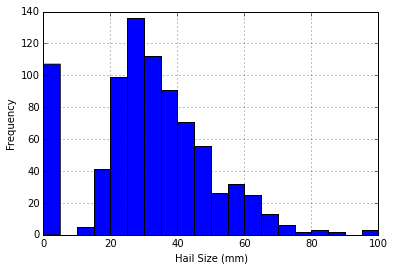

In [192]:
track_step_data["Hail_Size"].hist(bins=np.arange(0,105,5))
plt.xlabel("Hail Size (mm)")
plt.ylabel("Frequency")

The simplest and generally first choice for a statistical model is an ordinary linear regression. The model minimizes the mean squared error over the full training set. Since we used updraft helicity to identify the storm tracks, we start with building two linear models using the maximum updraft helicity and observed hail size. We first fit a linear model of the form $y=ax+b$. Then we fit a power-law model (think Z-R relationship) of the form $\ln(y)=a\ln(x) + b$. The training data and the two linear models are plotted below.

Standard deviation 13.9727287152
Correlation coefficient 0.247033149333
Linear model: a 0.0737755247445 b 28.7342687579
Power law model: a 0.230075805751 b 2.47805659888


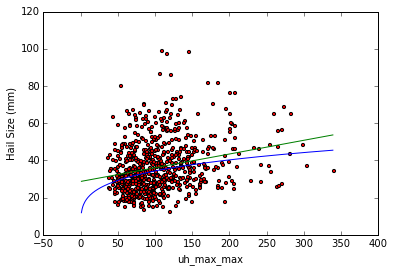

In [74]:
# We are filtering the unmatched storm tracks and storm tracks matched with unrealistically high values
filter_idx = (track_step_data['Hail_Size'] > 0) & (track_step_data['Hail_Size'] < 100)
x_var = "uh_max_max"
print "Standard deviation", track_step_data["Hail_Size"][filter_idx].std()
print "Correlation coefficient", np.corrcoef(track_step_data[x_var][filter_idx], 
                                             track_step_data['Hail_Size'][filter_idx])[0,1]
lr = LinearRegression()
log_lr = LinearRegression()
log_lr.fit(np.log(track_step_data.ix[filter_idx,[x_var]]), np.log(track_step_data['Hail_Size'][filter_idx]))
lr.fit(track_step_data.ix[filter_idx,[x_var]], track_step_data['Hail_Size'][filter_idx])
print "Linear model:", "a", lr.coef_[0], "b",lr.intercept_
print "Power law model:","a",log_lr.coef_[0], "b",log_lr.intercept_
plt.scatter(track_step_data.ix[filter_idx, x_var], 
            track_step_data.ix[filter_idx, 'Hail_Size'], 10, 'r')
uh_test_vals = np.arange(1 , track_step_data.ix[filter_idx, x_var].max())
power_hail_vals = np.exp(log_lr.intercept_) * uh_test_vals ** log_lr.coef_[0]
hail_vals = lr.intercept_ + lr.coef_[0] * uh_test_vals
plt.plot(uh_test_vals, power_hail_vals)
plt.plot(uh_test_vals, hail_vals)
plt.xlabel(x_var)
plt.ylabel("Hail Size (mm)")

While the linear regression fit does show a slight positive relationship with hail size, it also shows a large amount of variance. We could try to train a multiple linear regression from a subset of all the variables, but finding that subset is time consuming, and the resulting model still relies on the assumption of constant variance and normality. 

Alternatively, we could use a decision tree, which is a popular model from the machine learning community that performs variable selection, is robust against outliers and missing data, and does not rely on any parametric data model assumptions. While individual decision trees do not provide very high accuracy, randomized ensembles of decision trees are consistently among the best performing models in many applications. We will experiment with the Random Forest, a popular decision tree ensemble due to its ease of use and generally high accuracy. 

In [164]:
rf = RandomForestRegressor(n_estimators=500, min_samples_split=20, max_features="sqrt")
rf.fit(track_step_data.ix[filter_idx, 3:-1], track_step_data['Hail_Size'][filter_idx])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=20, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

Random forests provide a measure of how much each input variable affects the performance of the model called variable importance. It is a normalized measure of the decrease in error produced by each variable. 

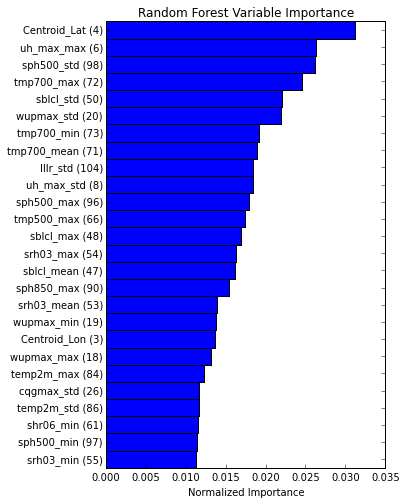

In [193]:
def plot_importances(num_features):
    feature_names = np.array(["{0} ({1:d})".format(f, x) for x, f in enumerate(track_step_data.columns[3:-1].values)])
    feature_ranks = np.argsort(rf.feature_importances_)
    plt.figure(figsize=(5,8))
    plt.barh(np.arange(feature_ranks.size)[-num_features:], 
             rf.feature_importances_[feature_ranks][-num_features:], height=1)
    plt.yticks(np.arange(feature_ranks.size)[-num_features:] + 0.5, feature_names[feature_ranks][-num_features:])
    plt.ylim(feature_names.size-num_features, feature_names.size)
    plt.xlabel("Normalized Importance")
    plt.title("Random Forest Variable Importance")
feature_slider = widgets.IntSlider(min=1, max=100, value=10)
feature_w = widgets.interactive(plot_importances, num_features=feature_slider)
display(feature_w)

We can validate the accuracy of the two models by comparing the hail size predictions for 4 June 2015 from each model. The root mean squared errors from each model are similar, but the random forest appears to be better at spreading the predictions over a larger range of hail sizes.

(20, 60)

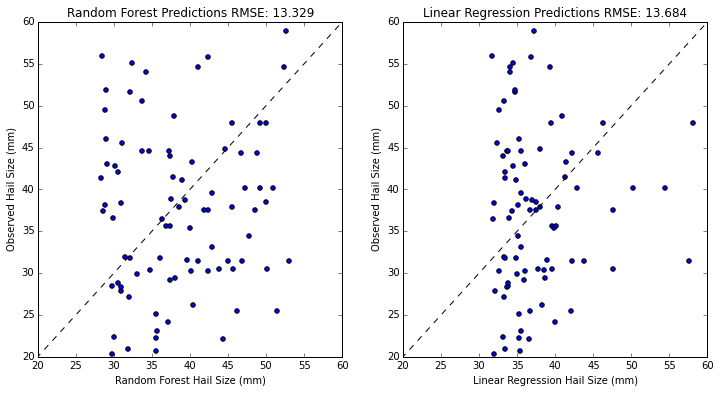

In [171]:
ver_idx = (track_forecast_data["Hail_Size"].values > 0) & (track_forecast_data["Hail_Size"].values < 100)
rf_preds = rf.predict(track_forecast_data.ix[ver_idx, 3:-1])
lr_preds = lr.predict(track_forecast_data.ix[ver_idx,["uh_max_max"]])
rf_rmse = np.sqrt(np.mean(np.power(rf_preds - track_forecast_data.ix[ver_idx, "Hail_Size"], 2)))
lr_rmse = np.sqrt(np.mean(np.power(lr_preds - track_forecast_data.ix[ver_idx, "Hail_Size"], 2)))
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.scatter(rf_preds, track_forecast_data.ix[ver_idx, "Hail_Size"])
plt.plot(np.arange(0, 65, 5), np.arange(0, 65, 5), "k--")
plt.xlabel("Random Forest Hail Size (mm)")
plt.ylabel("Observed Hail Size (mm)")
plt.title("Random Forest Predictions RMSE: {0:0.3f}".format(rf_rmse))
plt.xlim(20,60)
plt.ylim(20,60)
plt.subplot(1,2,2)
plt.scatter(lr_preds, track_forecast_data.ix[ver_idx, "Hail_Size"])
plt.plot(np.arange(0, 65, 5), np.arange(0, 65, 5), "k--")
plt.xlabel("Linear Regression Hail Size (mm)")
plt.ylabel("Observed Hail Size (mm)")
plt.title("Linear Regression Predictions RMSE: {0:0.3f}".format(lr_rmse))
plt.xlim(20,60)
plt.ylim(20,60)


Since each tree in the random forest produces an independent output, a probability density function can be generated from them for each prediction. To translate the predictions into probabilities, two methods can be used. A kernel density estimate (KDE) uses a moving window to determine probability based on the concentration of events at particular values. The alternative approach is to assume a parametric distribution, such as a Gaussian, and fit the distribution parameters to your predictions. As the KDE is non-parametric, it is much better at identifying the longer tails and secondary peaks that may hint at the chance for extreme hail. The example below shows how the KDE and Gaussian distributions compare for all of the June 4 predictions.

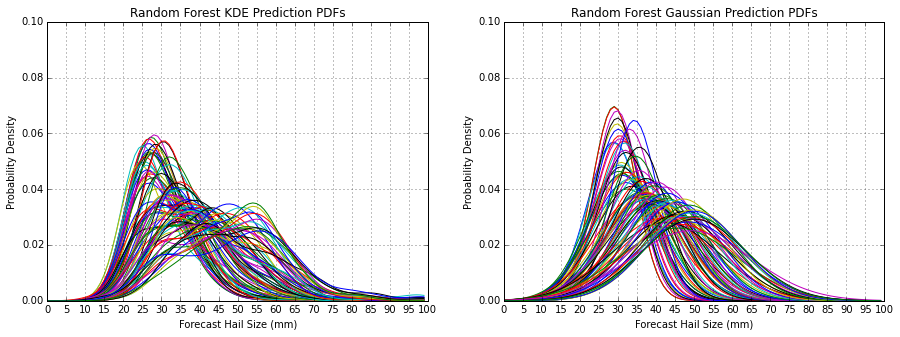

In [187]:
kde = KernelDensity(bandwidth=4)
bins = np.arange(0, 100)
bins = bins.reshape((bins.size, 1))
rf_tree_preds = np.array([t.predict(track_forecast_data.ix[ver_idx,3:-1]) for t in rf.estimators_])
mean_preds = rf_tree_preds.mean(axis=0)
sd_preds = rf_tree_preds.std(axis=0)
rf_pdfs = []
for r in range(rf_tree_preds.shape[1]):
    kde.fit(rf_tree_preds[:, r:r+1])
    rf_pdfs.append(np.exp(kde.score_samples(bins)))
rf_pdfs = np.array(rf_pdfs)
rf_cdfs = rf_pdfs.cumsum(axis=1)
pred_sorted = np.argsort(mean_preds)
def plot_pdfs(min_max):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.title("Random Forest KDE Prediction PDFs")
    for r in rf_pdfs[pred_sorted][min_max[0]:min_max[1]+1]:
        plt.plot(bins, r)
    plt.ylim(0, 0.1)
    plt.xlabel("Forecast Hail Size (mm)")
    plt.ylabel("Probability Density")
    plt.xticks(np.arange(0, 105, 5))
    plt.grid()
    plt.subplot(1,2,2)
    plt.title("Random Forest Gaussian Prediction PDFs")
    for r2, mean_pred in enumerate(mean_preds[pred_sorted][min_max[0]:min_max[1]+1]):
        plt.plot(bins, norm.pdf(bins, loc=mean_pred, scale=sd_preds[pred_sorted][r2]))
    plt.ylim(0, 0.1)
    plt.xlabel("Forecast Hail Size (mm)")
    plt.ylabel("Probability Density")
    plt.xticks(np.arange(0, 105, 5))
    plt.grid()
mm_slider = widgets.IntRangeSlider(min=0, max=rf_pdfs.shape[0])
display(widgets.interactive(plot_pdfs, min_max=mm_slider))

## Closing
This notebook demonstrated some of the power found in data science tools to turn raw data into valuable forecast information. Please continue to experiment with the parameters in this notebook and even try some of the other models found in scikit-learn and elsewhere. If you have any questions or comments, please email me at djgagne@ou.edu or find me on Twitter (Username: @DJGagneDos).

## Additional Resources
* [Personal webpage with hail forecasts and additional data](http://www.caps.ou.edu/~djgagne/)
* [Scientific Python tutorial](https://scipy-lectures.github.io/)
* [Scikit-learn documentation](http://scikit-learn.org/stable/documentation.html)
* [Pandas documentation](http://pandas.pydata.org/pandas-docs/stable/)
* Automating the Analysis of Spatial Grids by V. Lakshmanan: [Book](http://www.springer.com/us/book/9789400740747) and [Code](https://github.com/lakshmanok/asgbook)
* [Kaggle: Data Science competition site](https://kaggle.com) and [2015 AMS AI Competition](https://www.kaggle.com/c/how-much-did-it-rain)
* Valliappa Lakshmanan, Kurt Hondl, and Robert Rabin, 2009: An Efficient, General-Purpose Technique for Identifying Storm Cells in Geospatial Images. J. Atmos. Oceanic Technol., 26, 523–537.
doi: http://dx.doi.org/10.1175/2008JTECHA1153.1 
